In [1]:
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

plt.style.use("seaborn-v0_8")
import argparse
import logging
import os

from DA_PoC.common.observation_operator import (
    IdentityObservationOperator,
)  # RandomObservationOperator,; LinearObervationOperator,
from DA_PoC.dynamical_systems.lorenz_numerical_model import (
    LorenzWrapper,
    burn_model,
    create_lorenz_model_observation,
)
from DA_PoC.variational.incrementalCG import Incremental4DVarCG, pad_ragged

logging.basicConfig(level=logging.INFO)
logs_path = os.path.join(os.sep, "root", "log_dump", "smoke")
smoke_path = os.path.join(os.sep, "home", "smoke")
artifacts_path = os.path.join(smoke_path, "artifacts")

plt.set_cmap("magma")


rng = np.random.default_rng(seed=93)


def main(config, loaded_model=None):
    n = config["model"]["dimension"]
    window = 10
    lorenz = LorenzWrapper(n)
    x0_t = burn_model(n, 1000)
    lorenz.n_total_obs = window

    m = n * (window + 1)
    lorenz.set_observations(window)
    lorenz.H = lambda x: x

    identity_obs_operator = IdentityObservationOperator(m)
    l_model_randobs = create_lorenz_model_observation(
        lorenz, identity_obs_operator, test_consistency=False
    )

    def get_next_obs(x0):
        return lorenz.get_next_observations(
            x0,
            model_error_sqrt=config["DA"]["model_error_sqrt"],
            obs_error_sqrt=config["DA"]["obs_error_sqrt"],
        )

    # obs, x_t, truth = get_next_obs(x0_t)

    n_cycle = config["DA"]["n_cycle"]  # 3
    n_outer = config["DA"]["n_outer"]  # 10
    n_inner = config["DA"]["n_inner"]  # 100
    log_file = config["DA"]["log_file"]


    DA_exp_dict = {}

    def create_DA_experiment(exp_name, prec):
        DA_exp = Incremental4DVarCG(
            state_dimension=n,
            bounds=None,
            numerical_model=l_model_randobs,
            observation_operator=identity_obs_operator,
            x0_run=x0_t,
            x0_analysis=None,
            get_next_observations=get_next_obs,
            n_cycle=n_cycle,
            n_outer=n_outer,
            n_inner=n_inner,
            prec=prec,
            plot=True,
            log_append=False,
        )
        DA_exp.GNlog_file = log_file
        DA_exp.exp_name = exp_name
        DA_exp_dict[exp_name] = DA_exp
        return DA_exp

    DA_baseline = create_DA_experiment("baseline", prec=None)

    for exp_name, DA_exp in DA_exp_dict.items():
        print(f"\n--- {exp_name} ---\n")
        DA_exp.run()

    for i, (exp_name, DA_exp) in enumerate(DA_exp_dict.items()):
        DA_exp.plot_residuals_inner_loop(
            f"C{i}", label=DA_exp.exp_name, cumulative=False
        )
    plt.legend()
    plt.ylim([1e-9, 1e2])
    plt.show()
    return DA_exp_dict



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 800x550 with 0 Axes>

In [19]:
config=OmegaConf.load("config.yaml")


In [28]:
config['DA']['model_error_sqrt'] = 0.
config['DA']['obs_error_sqrt'] = 0

In [29]:
print(config['DA'])

{'n_cycle': 5, 'n_outer': 5, 'n_inner': 100, 'model_error_sqrt': 0.0, 'obs_error_sqrt': 0, 'log_file': '/home/smoke/artifacts/DA_logs.csv'}


Observation operator set already
lorenz.cost_function(x0_t)=9105.025804175692
numerical_model_lorenz.cost_function(x0_t)=9105.025804175692

--- baseline ---

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     0,     0, 874.1891,       42, 233.97, 2.042e+01, 2.042e+01
baseline,     0,     1,  20.9485,       36, 232.53, 1.823e+01, 1.823e+01
baseline,     0,     2,   0.0311,       31, 232.92, 1.916e+01, 1.916e+01
baseline,     0,     3,   0.0000,       20, 232.92, 1.916e+01, 1.916e+01
baseline,     0,     4,   0.0000,        1, 232.92, 1.916e+01, 1.916e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     1,     0,   0.0000,        1, 232.74, 2.295e+01, 2.295e+01
baseline,     1,     1,   0.0000,        0, 232.74, 2.295e+01, 2.295e+01
baseline,     1,     2,   0.0000,        0, 232.74, 2.295e+01, 2.295e+01
baseline,     1,     3,   0.0000,        0, 232.74, 2.295e+01, 2.295e+01
baseline,     1,     4,   0.0000,      

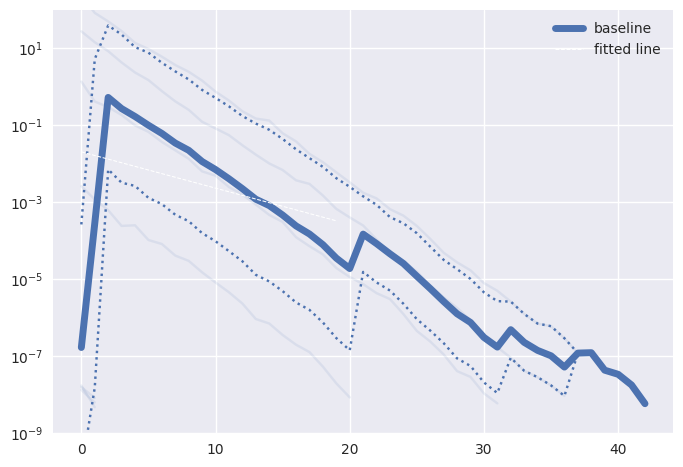

In [30]:
DA_exp_dict = main(config=config)

In [31]:
DA_exp_dict

{'baseline': <DA_PoC.variational.incrementalCG.Incremental4DVarCG at 0x7f97e7ed8f40>}

In [32]:
baseline = DA_exp_dict["baseline"]

In [33]:
baseline.plot

False

In [34]:
baseline.__dict__.keys()

dict_keys(['state_dimension', 'bounds', 'numerical_model', 'observation_operator', 'x0_run', 'x0_analysis', 'get_next_observations', 'n_cycle', 'n_outer', 'n_inner', 'preconditioner', 'plot', 'run_summary', 'GNlog_file', 'exp_name'])

In [35]:
for k, val in baseline.run_summary.items():
    try:
        print(f"{k}, {val.shape}")
    except AttributeError:
        try:
            print(f"{k}, {type(val)}, {len(val)}")
        except TypeError:
            print(f"{k}, {type(val)}")

truth_full, (100, 50)
analysis_full, (100, 50)
obs_full, (1100, 50)
n_iter_innerloop, <class 'list'>, 5
cost_outerloop, <class 'list'>, 5
sp_optimisation, <class 'list'>, 0
quad_errors, <class 'list'>, 5
l_model, <class 'DA_PoC.common.numerical_model.NumericalModel'>
inner_res_cycle, <class 'list'>, 5


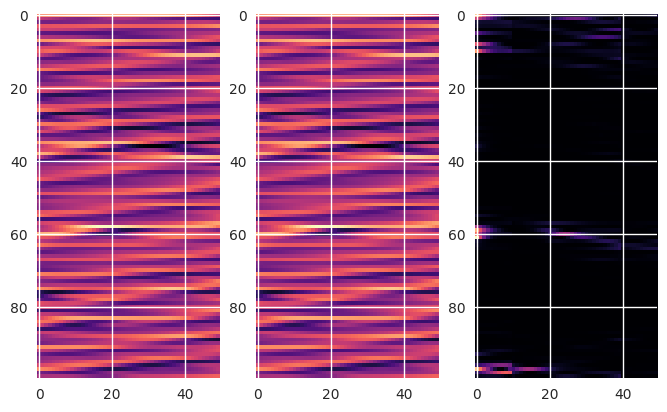

In [36]:
plt.subplot(1, 3, 1)
plt.imshow(baseline.run_summary['truth_full'])
plt.subplot(1, 3, 2)
plt.imshow(baseline.run_summary['analysis_full'])
plt.subplot(1, 3, 3)
plt.imshow((baseline.run_summary['truth_full'] - baseline.run_summary['analysis_full'])**2)


In [43]:
n = config["model"]["dimension"]
window = 10
lorenz = LorenzWrapper(n)
x0_t = burn_model(n, 1000)
lorenz.n_total_obs = window

m = n * (window + 1)
lorenz.set_observations(window)
lorenz.H = lambda x: x

identity_obs_operator = IdentityObservationOperator(m)
l_model_randobs = create_lorenz_model_observation(
    lorenz, identity_obs_operator, test_consistency=False
)
def get_next_obs(x0):
    return lorenz.get_next_observations(
        x0,
        model_error_sqrt=config["DA"]["model_error_sqrt"],
        obs_error_sqrt=config["DA"]["obs_error_sqrt"],
    )
obs, x_t, truth = get_next_obs(np.random.normal(size=100))
truth = truth[:, 1:]

# self.numerical_model.set_obs(self.observation_operator(obs.reshape(-1)))

Observation operator set already
lorenz.cost_function(x0_t)=10159.420131553265
numerical_model_lorenz.cost_function(x0_t)=10159.420131553265


(100, 11)
(100, 10)
1100


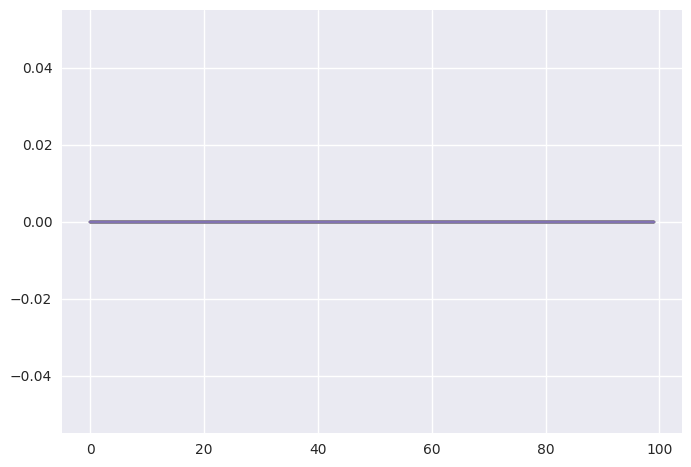

In [50]:
print(obs.shape)
print(truth.shape)
plt.plot(obs[...,1:] - truth)
print(identity_obs_operator.m)

In [56]:
obs_su = baseline.run_summary['obs_full'].reshape(11, 100, 50)
obs__ = obs_su[1:, ...]
print(obs__.shape)
identity_obs_operator.H.shape

(10, 100, 50)


(1100, 1100)

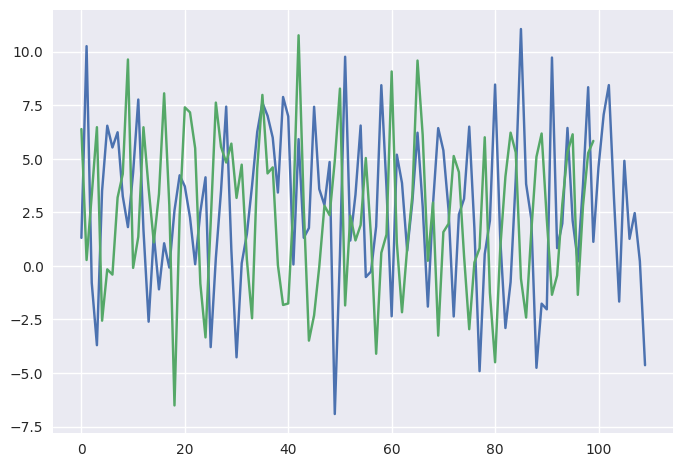

In [18]:
plt.plot(baseline.run_summary['obs_full'][1::10, 0])
plt.plot(baseline.run_summary['truth_full'][..., 0])

In [54]:
baseline.run_summary['truth_full'].shape

(100, 50)